## Overview

In this tutorial, we will learn how to use deep learning to compose images in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as **neural style transfer**! This is a technique outlined in [Leon A. Gatys' paper, A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576), which is a great read, and you should definitely check it out. 

But, what is neural style transfer?

Neural style transfer is an optimization technique used to take three images, a **content** image, a **style reference** image (such as an artwork by a famous painter), and the **input** image you want to style -- and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.


For example, let’s take an image of this turtle and Katsushika Hokusai's *The Great Wave off Kanagawa*:

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/Green_Sea_Turtle_grazing_seagrass.jpg?raw=1" alt="Drawing" style="width: 200px;"/>
<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/The_Great_Wave_off_Kanagawa.jpg?raw=1" alt="Drawing" style="width: 200px;"/>

[Image of Green Sea Turtle](https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg)
-By P.Lindgren [CC BY-SA 3.0  (https://creativecommons.org/licenses/by-sa/3.0)], from Wikimedia Commons


Now how would it look like if Hokusai decided to paint the picture of this Turtle exclusively with this style? Something like this?

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/wave_turtle.png?raw=1" alt="Drawing" style="width: 500px;"/>

Is this magic or just deep learning? Fortunately, this doesn’t involve any witchcraft: style transfer is a fun and interesting technique that showcases the capabilities and internal representations of neural networks.  

The principle of neural style transfer is to define two distance functions, one that describes how different the content of two images are , $L_{content}$, and one that describes the difference between two images in terms of their style, $L_{style}$. Then, given three images, a desired style image, a desired content image, and the input image (initialized with the content image), we try to transform the input image to minimize the content distance with the content image and its style distance with the style image. 
In summary, we’ll take the base input image, a content image that we want to match, and the style image that we want to match. We’ll transform the base input image by minimizing the content and style distances (losses) with backpropagation, creating an image that matches the content of the content image and the style of the style image. 

### Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts

* **Eager Execution** - use TensorFlow's imperative programming environment that evaluates operations immediately 
  * [Learn more about eager execution](https://www.tensorflow.org/programmers_guide/eager)
  * [See it in action](https://www.tensorflow.org/get_started/eager)
* ** Using [Functional API](https://keras.io/getting-started/functional-api-guide/) to define a model** - we'll build a subset of our model that will give us access to the necessary intermediate activations using the Functional API 
* **Leveraging feature maps of a pretrained model** - Learn how to use pretrained models and their feature maps 
* **Create custom training loops** - we'll examine how to set up an optimizer to minimize a given loss with respect to input parameters

### We will follow the general steps to perform style transfer:

1. Visualize data
2. Basic Preprocessing/preparing our data
3. Set up loss functions 
4. Create model
5. Optimize for loss function

**Audience:** This post is geared towards intermediate users who are comfortable with basic machine learning concepts. To get the most out of this post, you should: 
* Read [Gatys' paper](https://arxiv.org/abs/1508.06576) - we'll explain along the way, but the paper will provide a more thorough understanding of the task
* [Understand reducing loss with gradient descent](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent)

**Time Estimated**: 30 min


In [ ]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://ivanjayapurna.github.io/style_transfer/media/inputs/lion.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools
from google.colab import files

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

TensorFlow 1.x selected.


In [ ]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [ ]:
content_path = '/tmp/nst/lion.jpg'
style_path = '/tmp/nst/The_Great_Wave_off_Kanagawa.jpg'

In [ ]:
#limit gpu memory if needed
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  img = np.expand_dims(img, axis=0)
  return img

In [ ]:
def imshow(img, title=None):
  out = np.squeeze(img, axis=0)
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

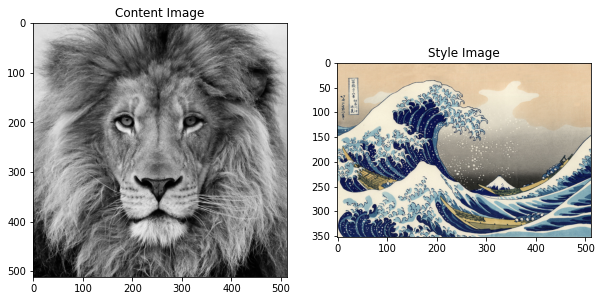

In [ ]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

Let's create methods that will allow us to load and preprocess our images easily. We perform the same preprocessing process as are expected according to the VGG training process. VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68]and with channels BGR.

In [ ]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg16.preprocess_input(img)
  return img

In order to view the outputs of our optimization, we are required to perform the inverse preprocessing step. Furthermore, since our optimized image may take its values anywhere between  −∞  and  ∞ , we must clip to maintain our values from within the 0-255 range.

In [ ]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  print(f"x_shape:{x.shape}")
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")


  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]   #covert to BGR

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
content_layers = ['block5_conv2'] #block5_conv2

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
#Get all layer's name in VGG16 and change your favorite output if needed.
vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
vgg16.trainable = False
for i, layer in enumerate(vgg16.layers):
  print(f"layer:{i}, name:{layer.name}")

58892288/58889256 [==============================] - 1s 0us/step
layer:0, name:input_1
layer:1, name:block1_conv1
layer:2, name:block1_conv2
layer:3, name:block1_pool
layer:4, name:block2_conv1
layer:5, name:block2_conv2
layer:6, name:block2_pool
layer:7, name:block3_conv1
layer:8, name:block3_conv2
layer:9, name:block3_conv3
layer:10, name:block3_pool
layer:11, name:block4_conv1
layer:12, name:block4_conv2
layer:13, name:block4_conv3
layer:14, name:block4_pool
layer:15, name:block5_conv1
layer:16, name:block5_conv2
layer:17, name:block5_conv3
layer:18, name:block5_pool


In [ ]:
def get_model():
  vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
  vgg16.trainable = False

  style_outputs = [vgg16.get_layer(name).output for name in style_layers]
  content_outputs = [vgg16.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs

  return models.Model(vgg16.input, model_outputs)

### Computing content loss
We will actually add our content losses at each desired layer. This way, each iteration when we feed our input image through the model (which in eager is simply `model(input_image)`!) all the content losses through the model will be properly compute and because we are executing eagerly, all the gradients will be computed. 

In [ ]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

### Computing style loss
Again, we implement our loss as a distance metric . 

In [ ]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

### Run Gradient Descent 
If you aren't familiar with gradient descent/backpropagation or need a refresher, you should definitely check out this [awesome resource](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent).

In this case, we use the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)* optimizer in order to minimize our loss. We iteratively update our output image such that it minimizes our loss: we don't update the weights associated with our network, but instead we train our input image to minimize loss. In order to do this, we must know how we calculate our loss and gradients. 

\* Note that L-BFGS, which if you are familiar with this algorithm is recommended, isn’t used in this tutorial because a primary motivation behind this tutorial was to illustrate best practices with eager execution, and, by using Adam, we can demonstrate the autograd/gradient tape functionality with custom training loops.


In [ ]:
def get_feature_representations(model, content_path, style_path):
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  style_outputs = model(style_image)
  content_outputs = model(content_image)

  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

### Computing the loss and gradients
Here we use [**tf.GradientTape**](https://www.tensorflow.org/programmers_guide/eager#computing_gradients) to compute the gradient. It allows us to take advantage of the automatic differentiation available by tracing operations for computing the gradient later. It records the operations during the forward pass and then is able to compute the gradient of our loss function with respect to our input image for the backwards pass.

In [ ]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  loss = style_score + content_score 
  return loss, style_score, content_score

Then computing the gradients is easy:

In [ ]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
    
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

### Optimization loop

In [ ]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
                       
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)

  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  iter_count = 1
  
  best_loss, best_img = float('inf'), None
  
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

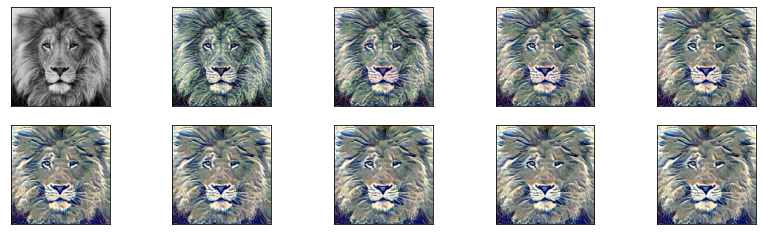

In [ ]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=500)

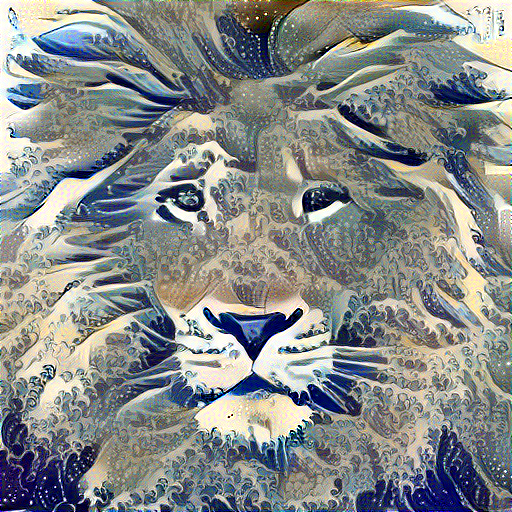

In [ ]:
Image.fromarray(best)

In [ ]:
im = Image.fromarray(best)
im.save( "base2Zhang_Daqian.png", "JPEG" )
files.download('base2Zhang_Daqian.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

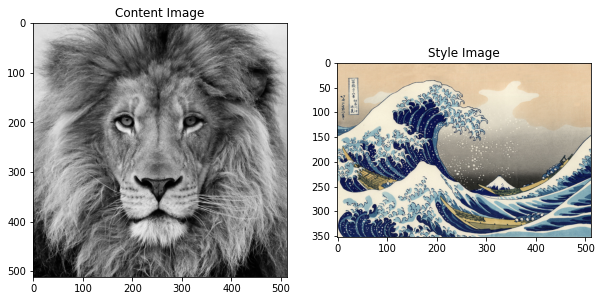

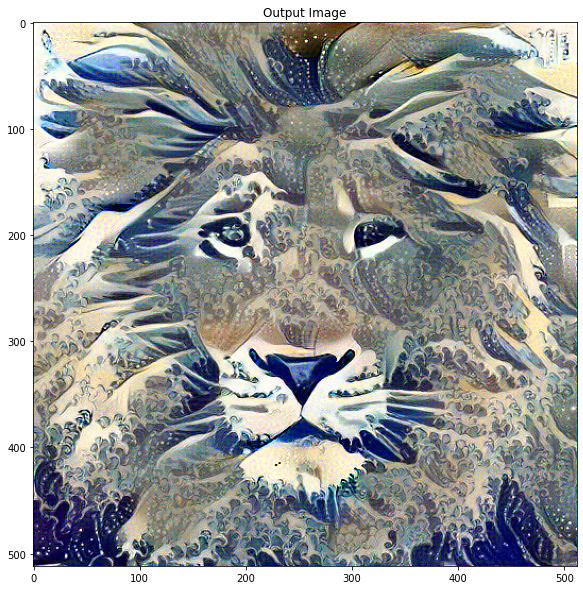

In [ ]:
show_results(best, content_path, style_path)